In [ ]:
!pip install stable-baselines3[extra] gymnasium pandas scikit-learn matplotlib shimmy --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 13.6 MB/s eta 0:00:00


In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from stable_baselines3 import DQN
import gym
from gym import spaces
from collections import Counter
import os

In [ ]:
df = pd.read_csv("/content/ad_bidding_dataset.csv")
data = df.copy()


In [ ]:
# Encode Categorical Features
label_encoders = {}
categorical_columns = ['ad_type', 'website', 'user_segment']

In [ ]:
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

In [ ]:
# Feature Set and Correlation Weights
features = ['day', 'hour', 'day_of_week', 'ad_type', 'website', 'user_segment',
            'cost', 'base_ctr', 'adjusted_ctr', 'won_auction',
            'impression_served', 'click_occurred', 'remaining_daily_budget']


In [ ]:
correlations = data[features + ['bid_amount']].corr()['bid_amount'].drop('bid_amount')
weights = correlations.abs()
weights /= weights.sum()


In [ ]:
weights

,bid_amount
day,0.003961
hour,0.003140
day_of_week,0.004268
ad_type,0.005522
website,0.011988
user_segment,0.009463
cost,0.116433
base_ctr,0.124455
adjusted_ctr,0.125998
won_auction,0.247122


In [ ]:
# Weighted State Vectors
state_vectors = data[features].multiply(weights, axis=1)
state_vectors['bid_amount'] = data['bid_amount']
state_vectors['website'] = data['website']
state_vectors['click_occurred'] = data['click_occurred']

In [ ]:
# Custom Gym Environment for DQN (Discrete Bidding)
class AdBiddingEnv(gym.Env):
    def __init__(self, df, website_id=0, bid_levels=21):
        super(AdBiddingEnv, self).__init__()

        self.df = df[df['website'] == website_id].reset_index(drop=True)
        self.n_samples = len(self.df)

        self.state_data = self.df.drop(columns=['bid_amount', 'website', 'click_occurred'])
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(self.state_data.shape[1],), dtype=np.float32)

        self.bid_values = np.linspace(0, 10, bid_levels)  # Discretized bid space
        self.action_space = spaces.Discrete(bid_levels)

        self.current_step = 0
        self.total_clicks = 0

    def reset(self):
        self.current_step = 0
        self.total_clicks = 0
        return self.state_data.iloc[self.current_step].values.astype(np.float32)

    def step(self, action):
        action_bid = self.bid_values[action]
        actual_bid = self.df.loc[self.current_step, 'bid_amount']
        click = self.df.loc[self.current_step, 'click_occurred']
        reward = 0

        if action_bid >= actual_bid:
            reward = click * (1.0 - abs(action_bid - actual_bid))

        self.total_clicks += click
        self.current_step += 1
        done = self.current_step >= self.n_samples

        if not done:
            next_state = self.state_data.iloc[self.current_step].values.astype(np.float32)
        else:
            next_state = np.zeros_like(self.state_data.iloc[0].values)

        return next_state, reward, done, {}

    def render(self):
        print(f"Step: {self.current_step}, Total Clicks: {self.total_clicks}")


In [ ]:
#  Train and Save Models for Each Website
website_labels = label_encoders['website'].classes_

# Save models for each website to avoid retraining
model_dir = "/content/models"
os.makedirs(model_dir, exist_ok=True)

for website_id, website_name in enumerate(website_labels):
    print(f"\n Training DQN for Website: {website_name} (ID: {website_id})")

    env = AdBiddingEnv(state_vectors, website_id)
    model = DQN("MlpPolicy", env, verbose=0)
    model.learn(total_timesteps=50000)

    # Save model for future use
    model.save(f"{model_dir}/model_{website_name}.zip")
    print(f" Model for {website_name} saved!")

print("\n🎓 Training Complete!")


 Training DQN for Website: blog (ID: 0)


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


 Model for blog saved!

 Training DQN for Website: entertainment (ID: 1)


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


 Model for entertainment saved!

 Training DQN for Website: gaming (ID: 2)


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


 Model for gaming saved!

 Training DQN for Website: news (ID: 3)


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


 Model for news saved!

 Training DQN for Website: shopping (ID: 4)


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


 Model for shopping saved!

 Training DQN for Website: social (ID: 5)


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


 Model for social saved!

🎓 Training Complete!


#**User Input and Evaluation Phase:**

Once models are saved, the user will enter their budget, and the model will load the pre-trained models to calculate the optimal allocation.

In [ ]:
# User-defined total budget (this can be entered after training is done)
user_budget = float(input("Enter your total advertising budget (e.g., 1000): "))

Enter your total advertising budget (e.g., 1000): 500


In [ ]:
clicks_per_website_budgeted = {}
spend_per_website = {}

In [ ]:
# Iterate through each website to compute the optimal allocation
for website_id, website_name in enumerate(website_labels):
    print(f"\nEvaluating strategy for: {website_name}")

    # Load pre-trained model for the website
    model = DQN.load(f"{model_dir}/model_{website_name}.zip")

    # Create environment for the website
    env = AdBiddingEnv(state_vectors, website_id)

    obs = env.reset()
    done = False
    spent = 0
    clicks = 0
    bid_log = []

    while not done and spent < user_budget:
        action, _ = model.predict(obs)
        bid_amount = float(env.bid_values[action])
        obs, reward, done, _ = env.step(action)

        # Spend budget only if click occurs (reward > 0)
        if reward > 0:
            spent += bid_amount
            clicks += 1
            bid_log.append(bid_amount)

    # Store results for the website
    clicks_per_website_budgeted[website_name] = clicks
    spend_per_website[website_name] = spent

# Normalize to get the percentage split of the budget
total_spent = sum(spend_per_website.values())

# Calculate the percentage allocation per website
allocation_percentages = {}
for website_name in spend_per_website:
    allocation_percentages[website_name] = (spend_per_website[website_name] / total_spent) * 100



Evaluating strategy for: blog

Evaluating strategy for: entertainment

Evaluating strategy for: gaming

Evaluating strategy for: news

Evaluating strategy for: shopping

Evaluating strategy for: social


In [ ]:
#  Show the final optimal budget allocation strategy
print("\n Optimal Budget Allocation (Percentage Split per Website):")
for website_name, percentage in allocation_percentages.items():
    print(f"{website_name.capitalize()}: {round(percentage, 2)}%")


 Optimal Budget Allocation (Percentage Split per Website):
Blog: 5.36%
Entertainment: 8.33%
Gaming: 39.29%
News: 14.29%
Shopping: 19.64%
Social: 13.1%


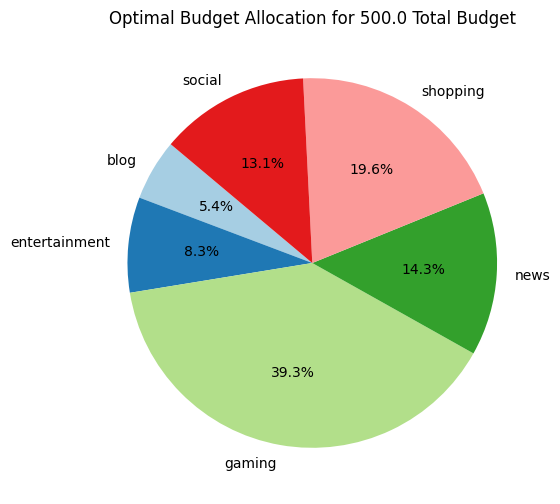

In [ ]:
# Plot Optimal Budget Allocation by Website
plt.figure(figsize=(10, 6))
plt.pie(allocation_percentages.values(), labels=allocation_percentages.keys(),
        autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title(f"Optimal Budget Allocation for {user_budget} Total Budget")
plt.show()

In [ ]:
# User-defined total budget (this can be entered after training is done)
user_budget = float(input("Enter your total advertising budget (e.g., 1000): "))
clicks_per_website_budgeted = {}
spend_per_website = {}
# Iterate through each website to compute the optimal allocation
for website_id, website_name in enumerate(website_labels):
    print(f"\nEvaluating strategy for: {website_name}")

    # Load pre-trained model for the website
    model = DQN.load(f"{model_dir}/model_{website_name}.zip")

    # Create environment for the website
    env = AdBiddingEnv(state_vectors, website_id)

    obs = env.reset()
    done = False
    spent = 0
    clicks = 0
    bid_log = []

    while not done and spent < user_budget:
        action, _ = model.predict(obs)
        bid_amount = float(env.bid_values[action])
        obs, reward, done, _ = env.step(action)

        # Spend budget only if click occurs (reward > 0)
        if reward > 0:
            spent += bid_amount
            clicks += 1
            bid_log.append(bid_amount)

    # Store results for the website
    clicks_per_website_budgeted[website_name] = clicks
    spend_per_website[website_name] = spent

# Normalize to get the percentage split of the budget
total_spent = sum(spend_per_website.values())

# Calculate the percentage allocation per website
allocation_percentages = {}
for website_name in spend_per_website:
    allocation_percentages[website_name] = (spend_per_website[website_name] / total_spent) * 100


Enter your total advertising budget (e.g., 1000): 100

Evaluating strategy for: blog

Evaluating strategy for: entertainment

Evaluating strategy for: gaming

Evaluating strategy for: news

Evaluating strategy for: shopping

Evaluating strategy for: social


In [ ]:
#  Show the final optimal budget allocation strategy
print("\n Optimal Budget Allocation (Percentage Split per Website):")
for website_name, percentage in allocation_percentages.items():
    print(f"{website_name.capitalize()}: {round(percentage, 2)}%")


 Optimal Budget Allocation (Percentage Split per Website):
Blog: 5.73%
Entertainment: 7.64%
Gaming: 42.04%
News: 9.55%
Shopping: 21.02%
Social: 14.01%


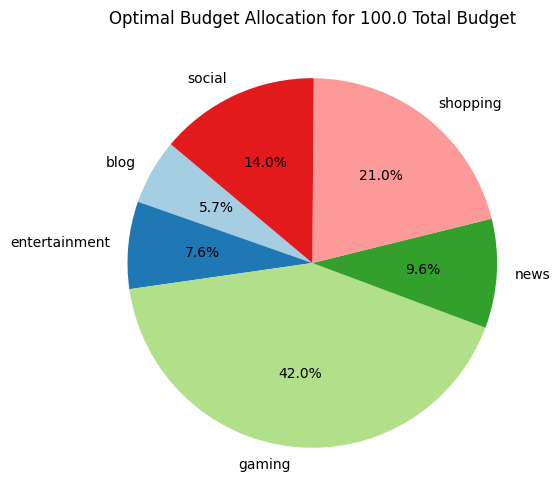

In [ ]:
# Plot Optimal Budget Allocation by Website
plt.figure(figsize=(10, 6))
plt.pie(allocation_percentages.values(), labels=allocation_percentages.keys(),
        autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title(f"Optimal Budget Allocation for {user_budget} Total Budget")
plt.show()